In [1]:
# Import packages
import pandas as pd
import numpy as np
import math
from scipy import stats
import warnings
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

# Dataset 1: Network Backup

In [2]:
# load dataset from csv
dataset = pd.read_csv('network_backup_dataset.csv')
data = []
weekdays = {'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}

for i in range(len(dataset)):
    temp = dataset.loc[i]
    day = weekdays[temp[1]] + (temp[0]-1)*7
    
    if len(data) == day:
        data.append([0,0,0,0,0])
        
    workflow = int(temp[3][10:])
    data[day][workflow] += temp[5]
    
data = np.array(data)

def printWorkflows(data, n_days):
    plt.figure(figsize=(15,8))
    N = data.shape[1]
    x = range(1,n_days+1)
    for k in range(N):
        plt.plot(x, data[0:n_days, k], label='work flow ' + str(k))

    plt.xlabel('Day')
    plt.ylabel('Backup Sizes (GB)')
    plt.title('Backup Sizes (first 20 days)')
    plt.xlim([1, n_days])
    plt.legend()
    plt.show()

# 1a

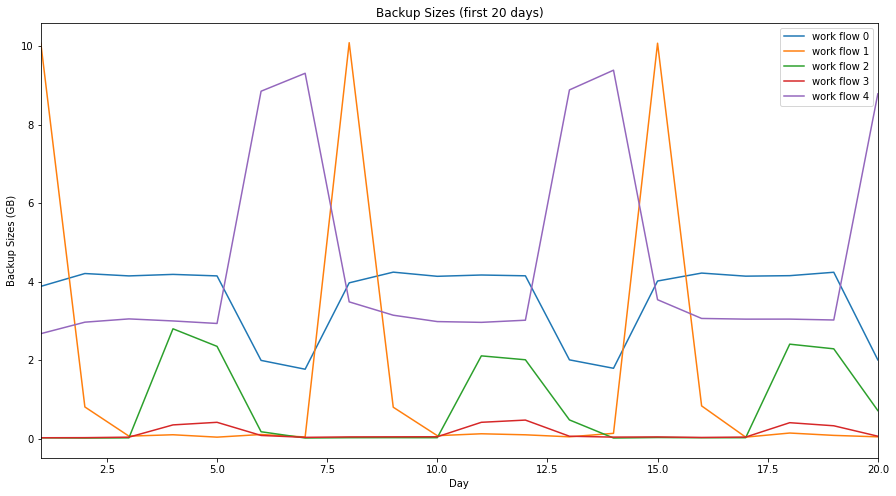

In [3]:
printWorkflows(data, 20)

# 1b

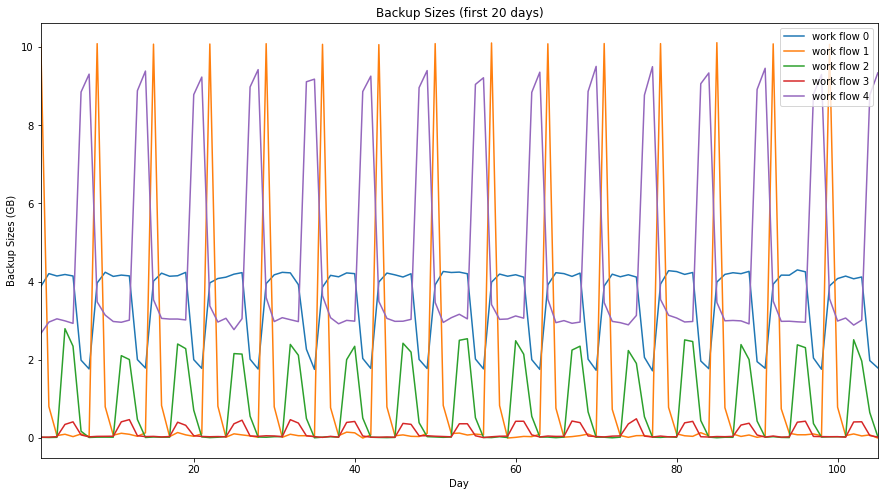

In [4]:
printWorkflows(data, 105)

# 1c

The workflows in both 20-day and 105-day plots are periodic with a period for each workflow to be about 7 days. Workflow_1 always have the largest backup size, followed by workflow_4, workflow_0, workflow_2, and workflow_3.


# 2a

In [5]:
# preprocessing
dataset = dataset.replace({'Day of Week':{'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}})
workflow = {}
file = {}

for j in dataset['File Name']:
    file[j] = int(j[5:])
    
for k in dataset['Work-Flow-ID']:
    workflow[k] = int(k[10:])

# replace int-strings with integers 
dataset = dataset.replace({'Work-Flow-ID':workflow})
dataset = dataset.replace({'File Name':file})

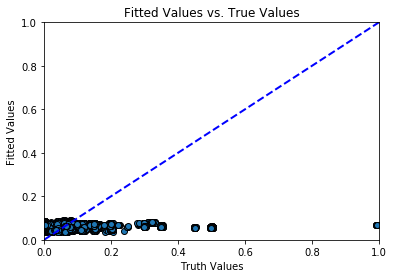

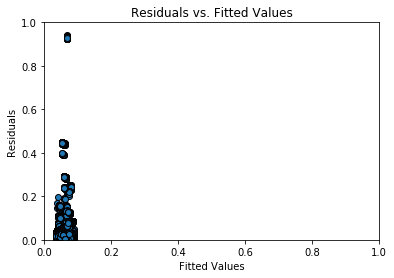

Training RMSE:  [0.10324315757540427, 0.10396677791654478, 0.10322579905879994, 0.1039464291963174, 0.10319511299798963, 0.10393838251390547, 0.10320263162336227, 0.10393638595896812, 0.10320098997274792, 0.10399160058862011]
Test RMSE:  [0.10671805207226827, 0.10018461438631411, 0.106849773893365, 0.10036709167781363, 0.10711585431838347, 0.10044533654683797, 0.10705026882029615, 0.1004666455097133, 0.10707418586815101, 0.09994712086112155]
Average training RMSE: 0.10358539364277801
Average test RMSE: 0.1036758476759903


In [6]:
# Basic linear regression model
kf = KFold(n_splits=10)
train_RMSE, test_RMSE, pred, truth = [], [], [], []

for i, j in kf.split(dataset.values):
    model = LinearRegression()
    train, test = dataset.values[i], dataset.values[j]
    model.fit(train[:,[0,1,2,3,4]], train[:,5])
    
    train_pred = model.predict(train[:,[0,1,2,3,4]])
    train_truth = train[:,5]
    train_RMSE.append(mean_squared_error(train_truth, train_pred))
    
    test_pred = model.predict(test[:,[0,1,2,3,4]])
    test_truth = test[:,5]
    test_RMSE.append(mean_squared_error(test_truth, test_pred))
    
    pred.extend(test_pred.tolist())
    truth.extend(test_truth.tolist())
    
residual = []
for i in range(len(pred)):
    residual.append(abs(truth[i] - pred[i]))

# pred vs. truth
# draw a diagonal line for comparison
plt.plot([0,1], [0,1], 'b--', lw=2)
plt.scatter(truth, pred, edgecolor = 'black')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Truth Values')
plt.ylabel('Fitted Values')
plt.title('Fitted Values vs. True Values')
plt.show()

# residual
plt.scatter(pred, residual, edgecolor = 'black')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

# report training RMSE and test RMSE
def getSqrt(RMSE):
    result = []
    for i in range(len(RMSE)):
        result.append(math.sqrt(RMSE[i]))
    return result

print('Training RMSE: ', getSqrt(train_RMSE))
print('Test RMSE: ', getSqrt(test_RMSE))
print('Average training RMSE:', math.sqrt(np.mean(train_RMSE)))
print('Average test RMSE:', math.sqrt(np.mean(test_RMSE)))

From the plots, we observe that the predicted value using the basic linear regression model centered at around 0.061 and the residuals centered at around 0.064. This implies that our model does not predict very well, as ideally we would want the first plot to mirror at the line y = x.

# 2b

From the plots, we observe that the predicted value using the random forest regression model predicts better than the basic linear regression model, because the fitted values vs. true values roughly mirror at the line y = x.


Progress: 

Number of features =  1
Number of trees =  50
Number of trees =  100
Number of trees =  150
Number of trees =  200
Number of features =  2
Number of trees =  50
Number of trees =  100
Number of trees =  150
Number of trees =  200
Number of features =  3
Number of trees =  50
Number of trees =  100
Number of trees =  150
Number of trees =  200
Number of features =  4
Number of trees =  50
Number of trees =  100
Number of trees =  150
Number of trees =  200
Number of features =  5
Number of trees =  50
Number of trees =  100
Number of trees =  150
Number of trees =  200


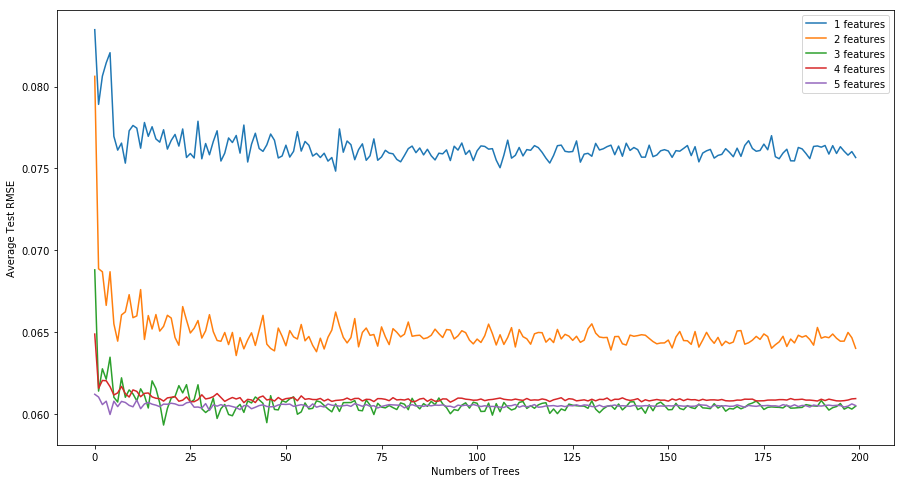

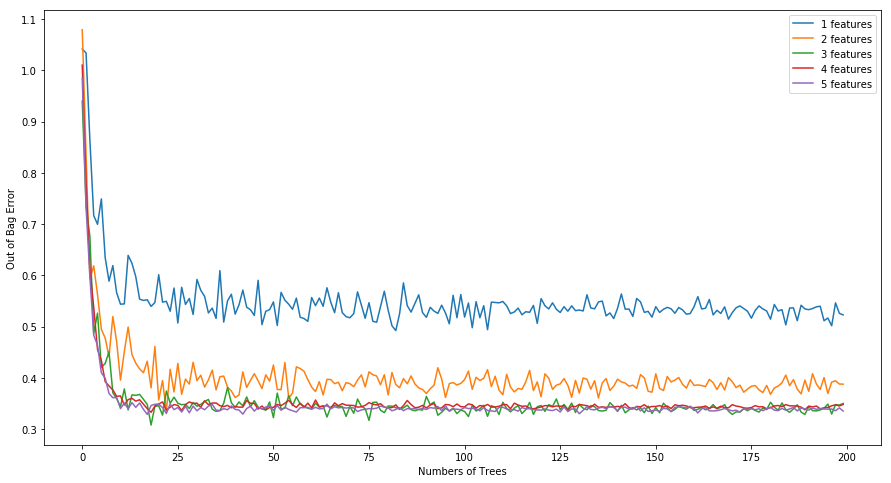

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

In [7]:
# random forest regression algorithm
warnings.filterwarnings('ignore')
print('Progress: ')
print()

for k in range(5): # num of features
    OOB = []
    avg_test_RMSE = []
    print('Number of features = ', k+1)
    
    for t in range(200): # num of trees
        if((t+1)%50 == 0):
            print('Number of trees = ', t+1)
            
        kf = KFold(n_splits=10)
        train_RMSE, test_RMSE = [], []
        
        for i, j in kf.split(dataset.values):
            model = RandomForestRegressor(n_estimators=t+1, max_features=k+1, max_depth=4, bootstrap=True, oob_score=True)
            train, test = dataset.values[i], dataset.values[j]
            model.fit(train[:,[0,1,2,3,4]], train[:,5])
            
            train_pred = model.predict(train[:,[0,1,2,3,4]])
            train_truth = train[:,5]
            train_RMSE.append(mean_squared_error(train_truth, train_pred))
    
            test_pred = model.predict(test[:,[0,1,2,3,4]])
            test_truth = test[:,5]
            test_RMSE.append(mean_squared_error(test_truth, test_pred))

        oob_score = model.oob_score_ 
        OOB.append(1-oob_score)
        avg_test_RMSE.append(math.sqrt(np.mean(test_RMSE)))
        
    plt.figure(figsize=(15,8))
    plt.figure(1)       
    plt.plot(avg_test_RMSE, label = str(k+1) + ' features')
    plt.xlabel('Numbers of Trees')
    plt.ylabel('Average Test RMSE')
    plt.legend(loc='upper right')
    
    plt.figure(figsize=(15,8))
    plt.figure(2)
    plt.plot(OOB, label = str(k+1) + ' features')
    plt.xlabel('Numbers of Trees')
    plt.ylabel('Out of Bag Error')    
    plt.legend(loc='upper right')
    
plt.show()

From the above plots, we observe that 4 and 5 features would yield the smallest average test RMSE and out of bag error. Furthermore, for out of bag errors, using 4 features would give a less fluctuated out of bag error compared to using 5 features. Additionally, for both average test RMSE and out of bag errors, the values decreases to steady state errors when the number of trees takes values greater than or equal to 20.

Progress: 

Max depth =  1
Max depth =  2
Max depth =  3
Max depth =  4
Max depth =  5
Max depth =  6
Max depth =  7
Max depth =  8
Max depth =  9
Max depth =  10
Max depth =  11
Max depth =  12
Max depth =  13
Max depth =  14
Max depth =  15
Max depth =  16
Max depth =  17
Max depth =  18
Max depth =  19
Max depth =  20


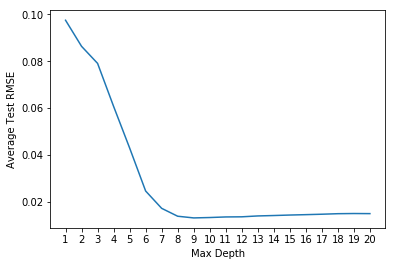

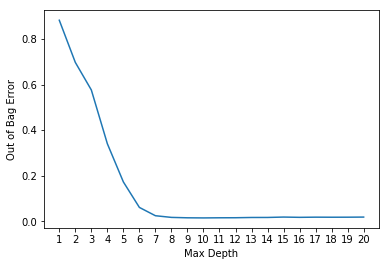

In [8]:
# sweep for max depth for better performance from 1 to 20
# set num of trees = 25 and num of features = 4

print('Progress: ')
print()

OOB = []
avg_test_RMSE = []
    
for d in range(20): # max depth
    print('Max depth = ', d+1)
    
    kf = KFold(n_splits=10)
    train_RMSE, test_RMSE = [], []
    
    for i, j in kf.split(dataset.values):
        model = RandomForestRegressor(n_estimators=25, max_features=4, max_depth=d+1, bootstrap=True, oob_score=True)
        train, test = dataset.values[i], dataset.values[j]
        model.fit(train[:,[0,1,2,3,4]], train[:,5])
        
        train_pred = model.predict(train[:,[0,1,2,3,4]])
        train_truth = train[:,5]
        train_RMSE.append(mean_squared_error(train_truth, train_pred))
    
        test_pred = model.predict(test[:,[0,1,2,3,4]])
        test_truth = test[:,5]
        test_RMSE.append(mean_squared_error(test_truth, test_pred))
        
    oob_score = model.oob_score_ 
    OOB.append(1-oob_score)
    avg_test_RMSE.append(math.sqrt(np.mean(test_RMSE)))
    
plt.figure(1)       
plt.plot(np.arange(1,21), avg_test_RMSE)
plt.xticks(np.arange(1,21))
plt.xlabel('Max Depth')
plt.ylabel('Average Test RMSE')

plt.figure(2)
plt.plot(np.arange(1,21), OOB)
plt.xticks(np.arange(1,21))
plt.xlabel('Max Depth')
plt.ylabel('Out of Bag Error')    

plt.show()

We choose to tune the max depth. From the plots, we see that the average test RMSE and out of bag error decrease to their steady state values for max depths greater than or equal to 8. Therefore, the parameters that achieves the best performance is {tree number = 25, number of features = 4, max depth = 8}.

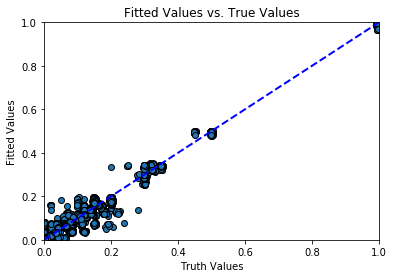

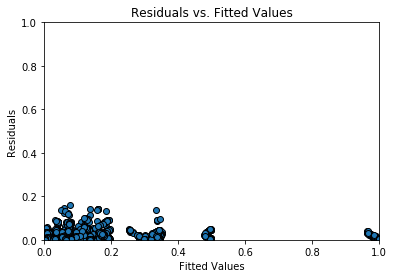

Training RMSE:  [0.01283124886549376, 0.012452434553455474, 0.013081046134048127, 0.012475386683071544, 0.01329969329340929, 0.012502087345851804, 0.01281522727115602, 0.012525986698320278, 0.013113311589385982, 0.012810128430025608]
Test RMSE:  [0.014885203211828424, 0.014023248493268149, 0.011754416916145576, 0.015066547747415497, 0.012383026486757705, 0.0153971356105986, 0.012594910873433809, 0.013497130898584559, 0.011820519048173658, 0.014185452334177746]
Average training RMSE: 0.012793849570491274
Average test RMSE: 0.013621876272763359
Out of bag error: 0.01733401747931873


In [9]:
warnings.filterwarnings('ignore')

kf = KFold(n_splits=10)
train_RMSE, test_RMSE, pred, truth = [], [], [], []

for i, j in kf.split(dataset.values):
    model = RandomForestRegressor(n_estimators=25, max_features=4, max_depth=8, bootstrap=True, oob_score=True)
    train, test = dataset.values[i], dataset.values[j]
    model.fit(train[:,[0,1,2,3,4]], train[:,5])
    
    train_pred = model.predict(train[:,[0,1,2,3,4]])
    train_truth = train[:,5]
    train_RMSE.append(mean_squared_error(train_truth, train_pred))
    
    test_pred = model.predict(test[:,[0,1,2,3,4]])
    test_truth = test[:,5]
    test_RMSE.append(mean_squared_error(test_truth, test_pred))
    
    pred.extend(test_pred.tolist())
    truth.extend(test_truth.tolist())
    
residual = []
for i in range(len(pred)):
    residual.append(abs(truth[i] - pred[i]))

# pred vs. truth
# draw a diagonal line for comparison
plt.plot([0,1], [0,1], 'b--', lw=2)
plt.scatter(truth, pred, edgecolor = 'black')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Truth Values')
plt.ylabel('Fitted Values')
plt.title('Fitted Values vs. True Values')
plt.show()

# residual
plt.scatter(pred, residual, edgecolor = 'black')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

def getSqrt(RMSE):
    result = []
    for i in range(len(RMSE)):
        result.append(math.sqrt(RMSE[i]))
    return result

print('Training RMSE: ', getSqrt(train_RMSE))
print('Test RMSE: ', getSqrt(test_RMSE))
print('Average training RMSE:', math.sqrt(np.mean(train_RMSE)))
print('Average test RMSE:', math.sqrt(np.mean(test_RMSE)))

oob_score = model.oob_score_ 
print("Out of bag error:", 1 - oob_score)

In [10]:
# feature importance

x = pd.DataFrame(dataset.iloc[:, [0,1,2,3,4]].values)
y = dataset.iloc[:, 5].values

model = RandomForestRegressor(n_estimators=25, max_features=4, max_depth=8, bootstrap=True, oob_score=True, random_state=1)
model.fit(x, y)
importance = model.feature_importances_
N = len(importance)

M = np.linspace(1, N, N)
temp = np.vstack((M,importance)).T
sort_f = sorted(temp, key=lambda x:x[1], reverse=True)

for i in range(N):
    result = sort_f[i][1]
    print('Feature', int(sort_f[i][0]-1), 'Importance = ', result)

Feature 2 Importance =  0.38933001041675014
Feature 1 Importance =  0.23359502384072703
Feature 4 Importance =  0.2084943295705703
Feature 3 Importance =  0.16679964892361154
Feature 0 Importance =  0.0017809872483410417


Based on the importance ranks, we see that the most important features are hour of the day, day of the week, file name, work-flow-ID, and week number, with descending order of feature importance.


In [11]:
# visualize decision tree
model = RandomForestRegressor(n_estimators=25, max_features=4, max_depth=4, bootstrap=True, oob_score=True)
model.fit(x, y)
est = model.estimators_[0]
export_graphviz(est, out_file='DecisionTree.dot')

#http://www.webgraphviz.com/

The root node in the decision tree corresponds to file name, which is not the most important feature we found in the previous part. This happens because the decision tree we realized in this part is an instance of many trees that are obtained using the random forest algorithm, in which the algorithm uses the many trees and votes on the most important feature based on these results.

# 2(c)


relu : 
Number of hidden layers =  2
Number of hidden layers =  5
Number of hidden layers =  10
Number of hidden layers =  50
Number of hidden layers =  100
Number of hidden layers =  150
Number of hidden layers =  200
Number of hidden layers =  250
Number of hidden layers =  300
Number of hidden layers =  350
Number of hidden layers =  400
Number of hidden layers =  450
Number of hidden layers =  500
Number of hidden layers =  550
Number of hidden layers =  600
logistic : 
Number of hidden layers =  2
Number of hidden layers =  5
Number of hidden layers =  10
Number of hidden layers =  50
Number of hidden layers =  100
Number of hidden layers =  150
Number of hidden layers =  200
Number of hidden layers =  250
Number of hidden layers =  300
Number of hidden layers =  350
Number of hidden layers =  400
Number of hidden layers =  450
Number of hidden layers =  500
Number of hidden layers =  550
Number of hidden layers =  600
tanh : 
Number of hidden layers =  2
Number of hidden layers =

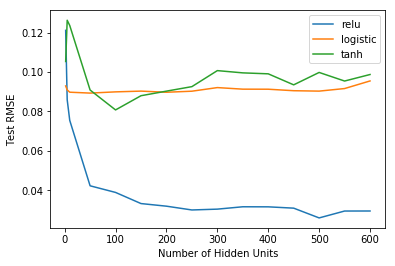

In [13]:
# NN regression model, one-hot encoding

dataset=pd.read_csv('network_backup_dataset.csv')

X = dataset.iloc[:, [0,1,2,3,4]].values
y = dataset.iloc[:, 5].values

label_enc = LabelEncoder()
X[:, 0] = label_enc.fit_transform(X[:, 0])
X[:, 1] = label_enc.fit_transform(X[:, 1])
X[:, 2] = label_enc.fit_transform(X[:, 2])
X[:, 3] = label_enc.fit_transform(X[:, 3])
X[:, 4] = label_enc.fit_transform(X[:, 4])

enc = OneHotEncoder()
X = enc.fit_transform(X)

hidden_layers = [2, 5, 10, 50,100,150,200,250,300,350,400,450,500,550,600]

def getRMSE(X, y, hidden_layers, activation_function):
    print(activation_function, ': ')
    
    RMSE = []
    for i in hidden_layers:
        print('Number of hidden layers = ', i)
        model = MLPRegressor(hidden_layer_sizes=i, activation=activation_function)
        scores = cross_validate(model, X, y, scoring=['neg_mean_squared_error'], cv=10, return_train_score=True)
        RMSE_test = np.mean(np.sqrt(np.abs(scores['test_neg_mean_squared_error'])))
        RMSE.append(RMSE_test)
    ax.plot(hidden_layers, RMSE, label=activation_function)
    ax.set_xlabel('Number of Hidden Units')
    ax.set_ylabel('Test RMSE')
    plt.legend()

fig, ax = plt.subplots()

getRMSE(X, y, hidden_layers, 'relu')
getRMSE(X, y, hidden_layers, 'logistic')
getRMSE(X, y, hidden_layers, 'tanh')

plt.show()

In [25]:
X = dataset.iloc[:, [0,1,2,3,4]].values
y = dataset.iloc[:, 5].values

# label encoding Day of Week 
labelencoder_X = LabelEncoder()
X[:, 0] = labelencoder_X.fit_transform(X[:, 0])
X[:, 1] = labelencoder_X.fit_transform(X[:, 1])
X[:, 2] = labelencoder_X.fit_transform(X[:, 2])
X[:, 3] = labelencoder_X.fit_transform(X[:, 3])
X[:, 4] = labelencoder_X.fit_transform(X[:, 4])

enc = OneHotEncoder()
X = enc.fit_transform(X)
model = MLPRegressor(hidden_layer_sizes=500, activation='relu')
scores = cross_validate(model, X, y, scoring=['neg_mean_squared_error'], cv=10, return_train_score=True)
train_RMSE = np.abs(scores['train_neg_mean_squared_error'])
test_RMSE = np.abs(scores['test_neg_mean_squared_error'])

# Splitting the dataset into the Training set and Test set
y_pred = cross_val_predict(model, X, y, cv=10)

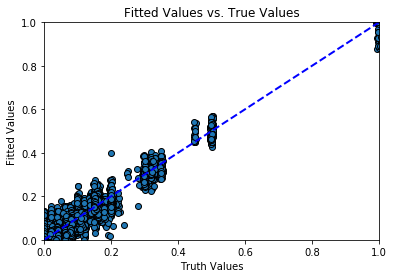

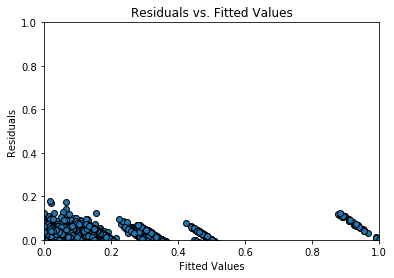

Training RMSE:  [0.013033520621743271, 0.011488275021004558, 0.011837716230382107, 0.01178104641979319, 0.011770870038597229, 0.011497613895948458, 0.011481105505302685, 0.011705993705187696, 0.012130389043401395, 0.011884188192458388]
Test RMSE:  [0.0250348286217776, 0.03366728214818529, 0.028623139055354976, 0.04484413143098156, 0.025577108340077283, 0.030666984934570315, 0.038244829910899905, 0.023994677263632667, 0.03817994757893701, 0.029015879981177627]
Average training RMSE: 0.011869088210160444
Average test RMSE: 0.032439485847771815


In [26]:
plt.plot([0,1], [0,1], 'b--', lw=2)
plt.scatter(y, y_pred, edgecolor = 'black')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Truth Values')
plt.ylabel('Fitted Values')
plt.title('Fitted Values vs. True Values')
plt.show()

plt.scatter(y_pred, y - y_pred, edgecolor = 'black')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

# report training RMSE and test RMSE
def getSqrt(RMSE):
    result = []
    for i in range(len(RMSE)):
        result.append(math.sqrt(RMSE[i]))
    return result

print('Training RMSE: ', getSqrt(train_RMSE))
print('Test RMSE: ', getSqrt(test_RMSE))
print('Average training RMSE:', math.sqrt(np.mean(train_RMSE)))
print('Average test RMSE:', math.sqrt(np.mean(test_RMSE)))

From the plots, we observe that although the points from the first plot center roughly around the line y=x, there are many points that are do not lie on the line. From the second plot, the residuals or errors of our predicted values range from 0 to a little less than 1. We conclude that the neural network regression model works better than the basic linear regression model, but worse than the random forest regression model, as ideally we would want the points from the first plot to lie roughly at the line y = x, and the points (residuals) from the second plot to be as close to 0 as possible.


# 2(d)

# (i) Linear regression model

-------------------------------------
Work Flow  0
(3687, 7)
Fold 1: train RMSE = 0.036, test RMSE = 0.037
Fold 2: train RMSE = 0.036, test RMSE = 0.035
Fold 3: train RMSE = 0.036, test RMSE = 0.037
Fold 4: train RMSE = 0.036, test RMSE = 0.037
Fold 5: train RMSE = 0.036, test RMSE = 0.036
Fold 6: train RMSE = 0.036, test RMSE = 0.034
Fold 7: train RMSE = 0.036, test RMSE = 0.037
Fold 8: train RMSE = 0.036, test RMSE = 0.034
Fold 9: train RMSE = 0.036, test RMSE = 0.037
Fold 10: train RMSE = 0.036, test RMSE = 0.034
*********
Average training RMSE: 0.035835233633998875
Average test RMSE: 0.03586346655296642


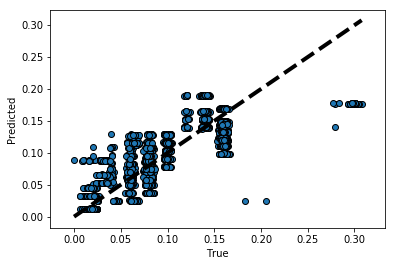

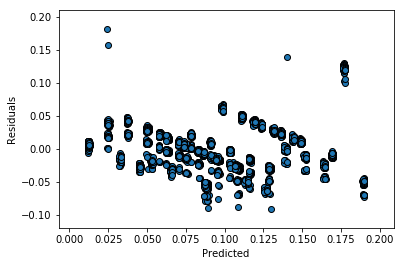

-------------------------------------
Work Flow  1
(3600, 7)
Fold 1: train RMSE = 0.146, test RMSE = 0.170
Fold 2: train RMSE = 0.151, test RMSE = 0.124
Fold 3: train RMSE = 0.146, test RMSE = 0.170
Fold 4: train RMSE = 0.151, test RMSE = 0.124
Fold 5: train RMSE = 0.146, test RMSE = 0.170
Fold 6: train RMSE = 0.151, test RMSE = 0.124
Fold 7: train RMSE = 0.146, test RMSE = 0.170
Fold 8: train RMSE = 0.151, test RMSE = 0.124
Fold 9: train RMSE = 0.146, test RMSE = 0.170
Fold 10: train RMSE = 0.151, test RMSE = 0.124
*********
Average training RMSE: 0.14874414236869585
Average test RMSE: 0.14709758822040112


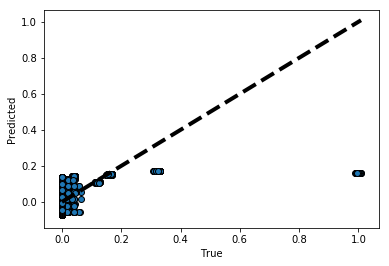

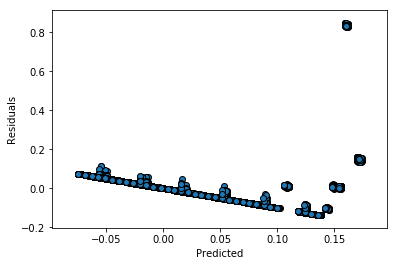

-------------------------------------
Work Flow  2
(3741, 7)
Fold 1: train RMSE = 0.044, test RMSE = 0.036
Fold 2: train RMSE = 0.042, test RMSE = 0.048
Fold 3: train RMSE = 0.044, test RMSE = 0.036
Fold 4: train RMSE = 0.042, test RMSE = 0.047
Fold 5: train RMSE = 0.044, test RMSE = 0.036
Fold 6: train RMSE = 0.042, test RMSE = 0.053
Fold 7: train RMSE = 0.043, test RMSE = 0.038
Fold 8: train RMSE = 0.042, test RMSE = 0.048
Fold 9: train RMSE = 0.044, test RMSE = 0.035
Fold 10: train RMSE = 0.042, test RMSE = 0.049
*********
Average training RMSE: 0.04290319403417192
Average test RMSE: 0.04257533084504969


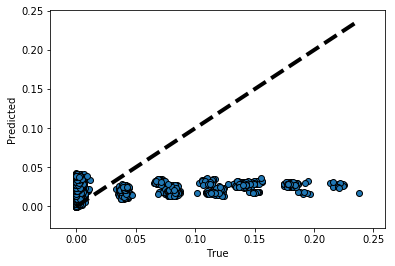

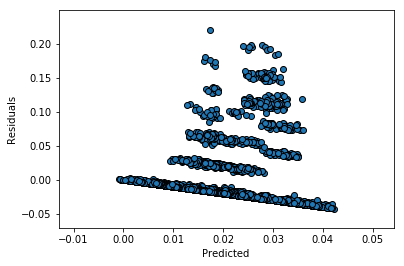

-------------------------------------
Work Flow  3
(3780, 7)
Fold 1: train RMSE = 0.007, test RMSE = 0.006
Fold 2: train RMSE = 0.007, test RMSE = 0.008
Fold 3: train RMSE = 0.007, test RMSE = 0.006
Fold 4: train RMSE = 0.007, test RMSE = 0.008
Fold 5: train RMSE = 0.007, test RMSE = 0.006
Fold 6: train RMSE = 0.007, test RMSE = 0.008
Fold 7: train RMSE = 0.007, test RMSE = 0.007
Fold 8: train RMSE = 0.007, test RMSE = 0.009
Fold 9: train RMSE = 0.007, test RMSE = 0.006
Fold 10: train RMSE = 0.007, test RMSE = 0.008
*********
Average training RMSE: 0.007242981713369212
Average test RMSE: 0.007186683488524774


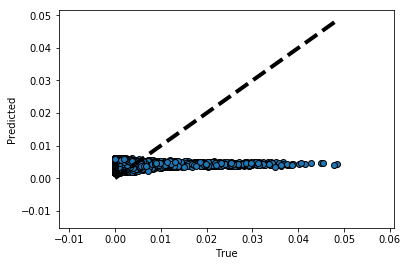

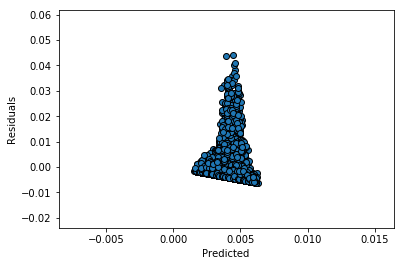

-------------------------------------
Work Flow  4
(3780, 7)
Fold 1: train RMSE = 0.087, test RMSE = 0.074
Fold 2: train RMSE = 0.085, test RMSE = 0.096
Fold 3: train RMSE = 0.087, test RMSE = 0.075
Fold 4: train RMSE = 0.085, test RMSE = 0.097
Fold 5: train RMSE = 0.087, test RMSE = 0.076
Fold 6: train RMSE = 0.085, test RMSE = 0.095
Fold 7: train RMSE = 0.087, test RMSE = 0.075
Fold 8: train RMSE = 0.085, test RMSE = 0.096
Fold 9: train RMSE = 0.087, test RMSE = 0.075
Fold 10: train RMSE = 0.085, test RMSE = 0.096
*********
Average training RMSE: 0.08591402576289187
Average test RMSE: 0.08533975477118064


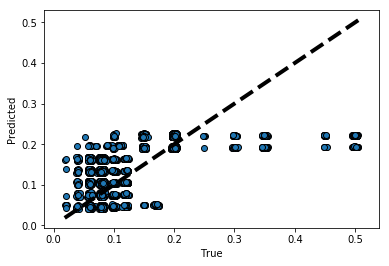

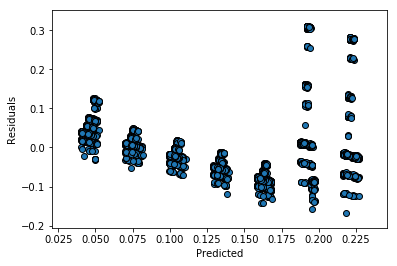

In [31]:
raw_data=pd.read_csv('network_backup_dataset.csv')

# Preprocess raw_data to data (numerical representation)
weekdays = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
dataset = np.zeros(raw_data.shape)
for i in range(raw_data.shape[0]):
    for j in range(raw_data.shape[1]):
        if j == 1: # Day of week
            dataset[i][j] = float(weekdays[raw_data.loc[i]['Day of Week']])
        elif j == 3: # workflow id
            dataset[i][j] = float(raw_data.loc[i]['Work-Flow-ID'].split('_')[-1])
        elif j == 4: # file name id
            dataset[i][j] = float(raw_data.loc[i]['File Name'].split('_')[-1])
        else:
            dataset[i][j] = float(raw_data.loc[i][j])

X = dataset[:,0:5]
y = dataset[:,5]

for i in range(5):
    print("-------------------------------------")
    print("Work Flow ", i)
    data_w = dataset[(dataset[:,3] == i)]
    
    print(data_w.shape)
    
    X_w = np.delete(data_w[:,0:5], 3, axis=1)
    y_w = data_w[:,5]
    scaler = StandardScaler()
    X_w = scaler.fit_transform(X_w, y_w)
    
    kf = KFold(10)
    totalTrainRMSE, totalTestRMSE = 0, 0
    
    k = 1
    model = LinearRegression()
    
    for train_w, test_w in kf.split(X_w):
        X_train, X_test = X_w[train_w], X_w[test_w]
        y_train, y_test = y_w[train_w], y_w[test_w]
        model.fit(X_train, y_train)
        pred_train, pred_test = model.predict(X_train), model.predict(X_test)

        rmse_train, rmse_test = math.sqrt(mean_squared_error(y_train, pred_train)), math.sqrt(mean_squared_error(y_test, pred_test))
        print("Fold %i: train RMSE = %.3f, test RMSE = %.3f" % (k, rmse_train, rmse_test))
        
        totalTrainRMSE += rmse_train
        totalTestRMSE += rmse_test
        
        k += 1
    
    print("*********")
    print('Average training RMSE:', totalTrainRMSE / 10)
    print('Average test RMSE:', totalTestRMSE / 10)
    
    model = LinearRegression()
    predicted = cross_val_predict(model, X_w, y_w, cv=10)

    fig, ax = plt.subplots()
    plt.scatter(y_w, predicted, edgecolors=(0, 0, 0))
    plt.plot([y_w.min(), y_w.max()], [y_w.min(), y_w.max()], 'k--', lw=4)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.show()

    fig, ax = plt.subplots()
    residuals = y_w - predicted
    plt.scatter(predicted, residuals, edgecolors=(0, 0, 0))
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.show()

Except for workflow 1, overall we seem to get better results than in point 2(a). Using a linear regression model on each workflow separetely seems to yield lower RMSE.

# (ii) Polynomial Function

-------------------------------------
Work Flow  0


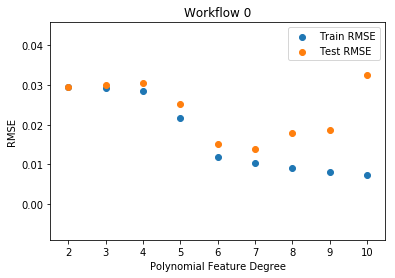

-------------------------------------
Work Flow  1


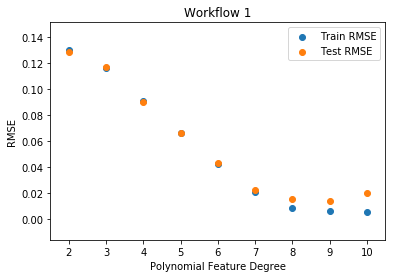

-------------------------------------
Work Flow  2


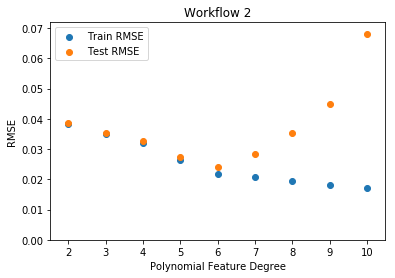

-------------------------------------
Work Flow  3


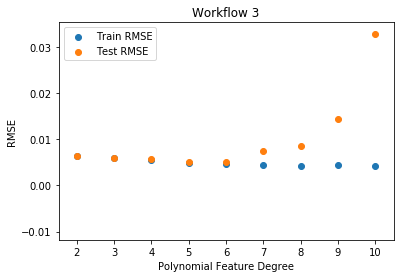

-------------------------------------
Work Flow  4


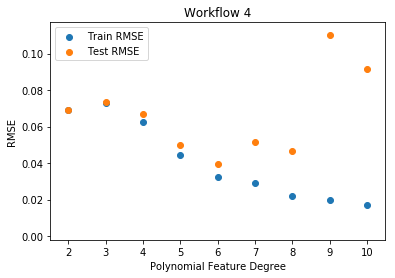

In [33]:
X = dataset[:,0:5]
y = dataset[:,5]

degrees = range(2, 11)

for i in range(5):
    print("-------------------------------------")
    print("Work Flow ", i)
    data_w = dataset[(dataset[:,3] == i)]
        
    X_w = np.delete(data_w[:,0:5], 3, axis=1)
    y_w = data_w[:,5]
    
    avgTrainRMSE, avgTestRMSE = [], []
    
    for d in degrees:
        #print("*********")
        #print("\t>>> Polynomial degree ", d)
        X_p = PolynomialFeatures(d).fit_transform(X_w)
        y_p = y_w

        scaler = StandardScaler()
        X_p = scaler.fit_transform(X_p, y_p)

        kf = KFold(10)
        totalTrainRMSE, totalTestRMSE = 0, 0

        k = 1

        for train_p, test_p in kf.split(X_p):
            X_train, X_test = X_p[train_p], X_p[test_p]
            y_train, y_test = y_p[train_p], y_p[test_p]

            model = LinearRegression()
            model.fit(X_train, y_train)
            pred_train, pred_test = model.predict(X_train), model.predict(X_test)

            rmse_train, rmse_test = math.sqrt(mean_squared_error(y_train, pred_train)), math.sqrt(mean_squared_error(y_test, pred_test))
            #print("Fold %i: train RMSE = %.3f, test RMSE = %.3f" % (k, rmse_train, rmse_test))

            totalTrainRMSE += rmse_train
            totalTestRMSE += rmse_test

            k += 1

        avgTrainRMSE.append(totalTrainRMSE / 10)
        avgTestRMSE.append(totalTestRMSE / 10)

    fig, ax = plt.subplots()
    plt.scatter(degrees, avgTrainRMSE, label="Train RMSE")
    plt.scatter(degrees, avgTestRMSE, label="Test RMSE")    
    plt.xticks(degrees)
    plt.title('Workflow %i' % i)
    plt.xlabel('Polynomial Feature Degree')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

We notice that overall after the threshold degree of 7, the generalization error of the model gets worse. This is probably due to overfitting as we keep increase the degree to force the polynomial model to fit the data.

Cross validation allows us to detect overfitting when there is a large difference between the RMSE of the train and test dataset. It thus allows us to improve the model without overfitting.

Average training RMSE: 0.04059796195254246
Average test RMSE: 0.041196185785529485


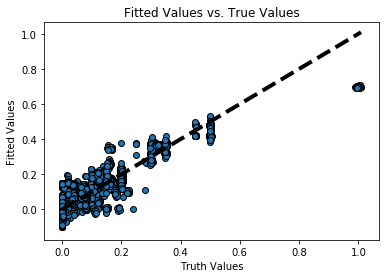

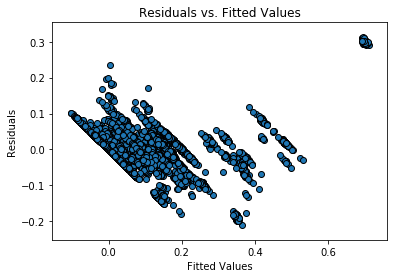

In [36]:
degree_opt = 7

X_p = PolynomialFeatures(degree_opt).fit_transform(X)
y_p = y

scaler = StandardScaler()
X_p = scaler.fit_transform(X_p, y_p)

kf = KFold(10)
totalTrainRMSE, totalTestRMSE = 0, 0

train_RMSE, test_RMSE, pred, truth = [], [], [], []

for train_p, test_p in kf.split(X_p):
    X_train, X_test = X_p[train_p], X_p[test_p]
    y_train, y_test = y_p[train_p], y_p[test_p]

    model = LinearRegression()
    model.fit(X_train, y_train)
    pred_train, pred_test = model.predict(X_train), model.predict(X_test)

    rmse_train, rmse_test = math.sqrt(mean_squared_error(y_train, pred_train)), math.sqrt(mean_squared_error(y_test, pred_test))

    totalTrainRMSE += rmse_train
    totalTestRMSE += rmse_test

print('Average training RMSE:', totalTrainRMSE / 10)
print('Average test RMSE:', totalTestRMSE / 10)

model = LinearRegression()
predicted = cross_val_predict(model, X_p, y_p, cv=10)

fig, ax = plt.subplots()
plt.scatter(y_p, predicted, edgecolors=(0, 0, 0))
plt.plot([y_p.min(), y_p.max()], [y_p.min(), y_p.max()], 'k--', lw=4)
plt.xlabel('Truth Values')
plt.ylabel('Fitted Values')
plt.title('Fitted Values vs. True Values')
plt.show()

fig, ax = plt.subplots()
residuals = y_p - predicted
plt.scatter(predicted, residuals, edgecolors=(0, 0, 0))
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

# 2(e)

In [40]:
X = dataset[:,0:5]
y = dataset[:,5]

avg_Train_RMSE = []
avg_Test_RMSE = []

for k in range(1,21):
    print('-----------------')
    print('k = ', k)
    kf = KFold(10)

    model = KNeighborsRegressor(n_neighbors=k)
    total_Train_RMSE = 0
    total_Test_RMSE = 0
    
    for train_kn, test_kn in kf.split(X):
        X_train, X_test = X[train_kn], X[test_kn]
        y_train, y_test = y[train_kn], y[test_kn]
        
        model.fit(X_train, y_train)
        pred_train, pred_test = model.predict(X_train), model.predict(X_test)

        RMSE_train, RMSE_test = math.sqrt(mean_squared_error(y_train, pred_train)), math.sqrt(mean_squared_error(y_test, pred_test))
        total_Train_RMSE += RMSE_train
        total_Test_RMSE += RMSE_test
        
    avg_Train_RMSE.append(total_Train_RMSE / 10)
    avg_Test_RMSE.append(total_Test_RMSE / 10)
    print('\tAverage training RMSE:', total_Train_RMSE / 10)
    print('\tAverage test RMSE:', total_Test_RMSE / 10)

-----------------
k =  1
	Average training RMSE: 0.0
	Average test RMSE: 0.020119075932672044
-----------------
k =  2
	Average training RMSE: 0.028907380918218435
	Average test RMSE: 0.033466704600186664
-----------------
k =  3
	Average training RMSE: 0.02996200874251308
	Average test RMSE: 0.035855453601765924
-----------------
k =  4
	Average training RMSE: 0.02840799208236241
	Average test RMSE: 0.03705553326662823
-----------------
k =  5
	Average training RMSE: 0.026955945204027866
	Average test RMSE: 0.042652328186235516
-----------------
k =  6
	Average training RMSE: 0.028394899025747534
	Average test RMSE: 0.04722385013456989
-----------------
k =  7
	Average training RMSE: 0.03242438991222532
	Average test RMSE: 0.04618222407603216
-----------------
k =  8
	Average training RMSE: 0.036334963171251275
	Average test RMSE: 0.04618159714169066
-----------------
k =  9
	Average training RMSE: 0.03944426270933827
	Average test RMSE: 0.04742608202741836
-----------------
k =  10
	

fig, ax = plt.subplots()
plt.plot(range(1,21), avg_Train_RMSE, label="Train RMSE")
plt.plot(range(1,21), avg_Test_RMSE, label="Test RMSE")    
plt.xlabel('Number of neighbors k')
plt.ylabel('RMSE')
plt.legend()
plt.show()

The best (lowest) RMSE is obtained when k = 2.

-- Average training RMSE: 0.028907380918218435

-- Average test RMSE: 0.033466704600186664

	Average training RMSE: 0.028907380918218435
	Average test RMSE: 0.033466704600186664


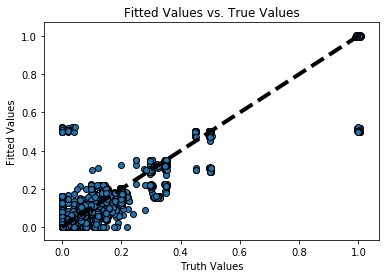

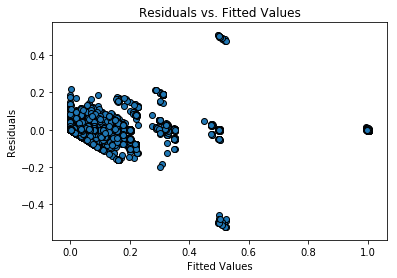

In [45]:
k_opt = 2

kf = KFold(10)

model = KNeighborsRegressor(n_neighbors=k_opt)

total_Train_RMSE = 0
total_Test_RMSE = 0

for train_kn, test_kn in kf.split(X):
    X_train, X_test = X[train_kn], X[test_kn]
    y_train, y_test = y[train_kn], y[test_kn]

    model.fit(X_train, y_train)
    pred_train, pred_test = model.predict(X_train), model.predict(X_test)

    RMSE_train, RMSE_test = math.sqrt(mean_squared_error(y_train, pred_train)), math.sqrt(mean_squared_error(y_test, pred_test))
    total_Train_RMSE += RMSE_train
    total_Test_RMSE += RMSE_test

print('\tAverage training RMSE:', total_Train_RMSE / 10)
print('\tAverage test RMSE:', total_Test_RMSE / 10)

predicted = cross_val_predict(model, X, y, cv=10)

fig, ax = plt.subplots()
plt.scatter(y, predicted, edgecolors=(0, 0, 0))
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.xlabel('Truth Values')
plt.ylabel('Fitted Values')
plt.title('Fitted Values vs. True Values')
plt.show()

fig, ax = plt.subplots()
residuals = y - predicted
plt.scatter(predicted, residuals, edgecolors=(0, 0, 0))
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

# 3

The best overall performance is obtained with the Random Forest Regression model with max_depth = 8. It has the lowest RMSE value of all: 0.0129

1.Linear Regression: produced the worst results (average RMSE of 0.1). However, when we used a linear regression model on each workflow separetely, we got much better results for all workflows except workflow 1 for which the average RMSE didn't improve. This regression is the simplest. It has the advantage to be the fastest.

2.Random Forest Regression Model: produced the best results (average RMSE of 0.0129). This method is best for handling categorical features. On top of that, it can evaluate the importance of each feature and calculate the error rate of the algorithm using out of bag data.

3.Neural Network Regression Model: good at handling sparse features as it was mainly dealing with the sparse matrix with all features one-hot encoded. This model works better than the basic linear regression model, but worse than the random forest regression model.

4.Polynomial Function Regression Model: better than linear regression to predict the backup size for the workflows. It works well with numerical features. We need to make sure to select the right degree as threshold to avoid overfitting.

5.K-Nearest Neighbor Regression Model: it provides decent results once we select the right k, even comparable to the best results obtained with polynomial regression. It is not good to handle sparse features.


# Dataset2: Boston Housing Dataset 

In [44]:
print("1. Load the dataset")
house_data = pd.read_csv('./housing_data.csv', header = None)
x = house_data.iloc[:,0:13].values        # Feature variables
y = house_data.iloc[:,13].values          # Target variables
feature = ['Constant','CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']
print("done")

1. Load the dataset
done


In [45]:
def significanceAnalysis(model, feature, x, y) :
    model.fit(x,y)
    params = np.append(model.intercept_,model.coef_)
    newX = pd.DataFrame({"Constant":np.ones(len(x))}).join(pd.DataFrame(x))
    MSE = mean_squared_error(y,model.predict(x))
    standard_error = np.sqrt(MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal()))
    t_values = params/standard_error
    p_values =[2*(1-stats.t.cdf(np.abs(i),len(x))) for i in t_values]

    analyzer = pd.DataFrame()
    analyzer["Coefficients"],analyzer["Standard Errors"],analyzer["t values"],analyzer["p values"] = \
        [params,standard_error,t_values,p_values]
    analyzer.index = feature
    return analyzer


In [46]:
print("Feature analysis")
lr = LinearRegression(fit_intercept=True, n_jobs = 2)  # Linear Regression Model

# Analyze the significance of different variables
print("---------------Signifiance of different variables---------------")
lrAnalysis = significanceAnalysis(lr,feature,x,y)
lrCoeff = lrAnalysis.iloc[:,0].values
print(lrAnalysis)
print(" ")

Feature analysis
---------------Signifiance of different variables---------------
          Coefficients  Standard Errors   t values      p values
Constant     36.459488         5.032362   7.245005  1.623146e-12
CRIM         -0.108011         0.032407  -3.332948  9.222325e-04
ZN            0.046420         0.013536   3.429351  6.544318e-04
INDUS         0.020559         0.060639   0.339033  7.347254e-01
CHAS          2.686734         0.849577   3.162437  1.658464e-03
NOX         -17.766611         3.766531  -4.716970  3.100926e-06
RM            3.809865         0.412103   9.244932  0.000000e+00
AGE           0.000692         0.013026   0.053143  9.576391e-01
DIS          -1.475567         0.196676  -7.502521  2.835510e-13
RAD           0.306049         0.065422   4.678070  3.721444e-06
TAX          -0.012335         0.003708  -3.326349  9.438660e-04
PTRATIO      -0.952747         0.129004  -7.385397  6.306067e-13
B             0.009312         0.002649   3.515771  4.778828e-04
LSTAT   

The most significant features: 'RM', 'LSTAT', 'DIS', 'PTRATIO'

The laest significant features: 'INDUS', 'AGE'

# Linear Regression

10 fold cross validation

The RMSE of test is the following: 
[ 3.04744921  3.76181913  3.75148053  5.93354231  5.64669077  4.45374875
  3.15392917 12.9759539   5.77319193  3.3106511 ]
The average RMSE of test is 5.89

The RMSE of train is the following: 
[4.83355236 4.78351694 4.81830623 4.55759835 4.61902872 4.72902737
 4.82982623 3.45820725 4.6461054  4.81550033]
The average RMSE of train is 4.63

The following two plots using the whole dataset


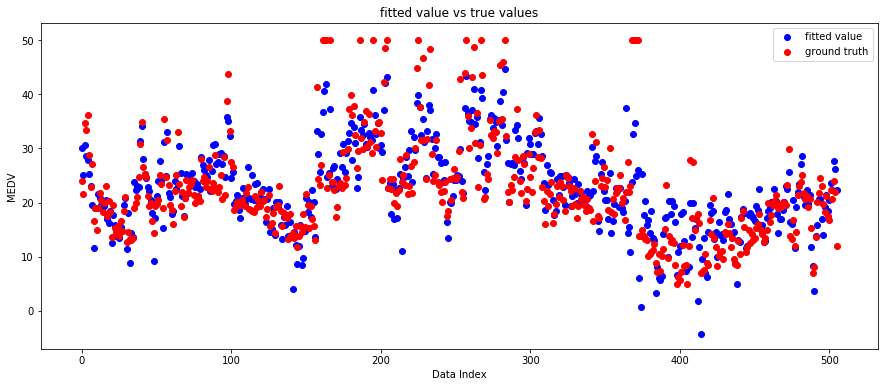

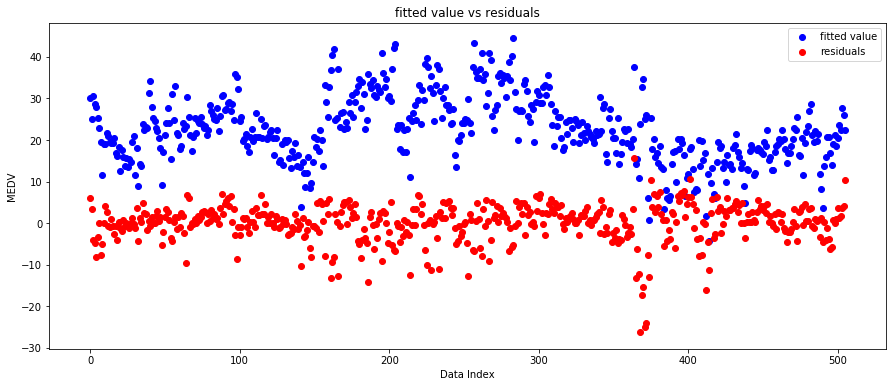

In [47]:
print("10 fold cross validation\n")
# 10 fold cross validation
kf = KFold(n_splits=10, shuffle=False, random_state=None)
mse_test, mse_train = [],[]
for trainIndex, testIndex in kf.split(house_data) :
    x_train,x_test = x[trainIndex], x[testIndex]
    y_train, y_test = y[trainIndex], y[testIndex]
    lr.fit(x_train,y_train)
    mse_test.append(mean_squared_error(y_test,lr.predict(x_test)))
    mse_train.append(mean_squared_error(y_train,lr.predict(x_train)))


print("The RMSE of test is the following: ")
print(np.sqrt(mse_test))
print("The average RMSE of test is %.2f" % np.sqrt(sum(mse_test)/10))
print("\nThe RMSE of train is the following: ")
print(np.sqrt(mse_train))
print("The average RMSE of train is %.2f" % np.sqrt(sum(mse_train)/10))

# Whole dataset 
print("\nThe following two plots using the whole dataset")
predictions, ground_truth = [],[]
xWhole = lr.fit(x,y).predict(x)
predictions.extend(xWhole.tolist())
ground_truth.extend(y)

# Plot 1: fitted values vs true values
fig = plt.figure(figsize=(15,6))   
index = range(0, 506)
plt.scatter(index, predictions, label='fitted value', c = 'b')
plt.scatter(index, ground_truth, label='ground truth', c = 'r')
plt.legend()
plt.ylabel("MEDV")
plt.xlabel('Data Index')
plt.title("fitted value vs true values")
plt.show()    
# Plot 2 : residuals vs fitted values
residuals = [i-j for i, j in zip(predictions, ground_truth)]
fig = plt.figure(figsize=(15,6))   
plt.scatter(index, predictions, label='fitted value', c = 'b')
plt.scatter(index, residuals, label='residuals', c = 'r')
plt.legend()
plt.ylabel("MEDV")
plt.xlabel('Data Index')
plt.title("fitted value vs residuals")
plt.show() 

# Ridge Regularizer

In [48]:
avg_rmse_test = []
alpha = []
for a in np.arange(0.1,60,0.1):
    ridge = Ridge(alpha=a)
    # 10 fold cross validation
    kf = KFold(n_splits=10, shuffle=False, random_state=None)
    mse_test= []
    for trainIndex, testIndex in kf.split(house_data) :
        x_train,x_test = x[trainIndex], x[testIndex]
        y_train, y_test = y[trainIndex], y[testIndex]
        ridge.fit(x_train,y_train)
        mse_test.append(mean_squared_error(y_test,ridge.predict(x_test)))
    avg_rmse_test.append(np.sqrt(sum(mse_test)/10))
    alpha.append(a)

print("The best alpha is %f\n" % alpha[avg_rmse_test.index(min(avg_rmse_test))])

# 10 fold cross validation with best alpha
kf = KFold(n_splits=10)
mse_test, mse_train = [],[]
ridge = Ridge(alpha = alpha[avg_rmse_test.index(min(avg_rmse_test))])
print("---------------Signifiance of different variables---------------")
ridgeAnalysis = significanceAnalysis(ridge, feature, x, y)
ridgeCoeff = ridgeAnalysis.iloc[:,0].values
print(ridgeAnalysis) 
for trainIndex, testIndex in kf.split(house_data) :
    x_train,x_test = x[trainIndex], x[testIndex]
    y_train, y_test = y[trainIndex], y[testIndex]
    ridge.fit(x_train,y_train)
    mse_test.append(mean_squared_error(y_test,ridge.predict(x_test)))
    mse_train.append(mean_squared_error(y_train,ridge.predict(x_train)))

print("\nrmse of test with the best alpha: ")
print(np.sqrt(mse_test))
print("The average RMSE of test is %f" % np.sqrt(sum(mse_test)/10))
print("\nrmse of train with the best alpha: ")
print(np.sqrt(mse_train))
print("The average RMSE of test is %f" % np.sqrt(sum(mse_train)/10))

The best alpha is 59.900000

---------------Signifiance of different variables---------------
          Coefficients  Standard Errors   t values      p values
Constant     33.261778         5.199325   6.397326  3.604272e-10
CRIM         -0.102329         0.033482  -3.056193  2.360071e-03
ZN            0.053238         0.013985   3.806692  1.580990e-04
INDUS        -0.051561         0.062651  -0.822992  4.109001e-01
CHAS          0.901308         0.877764   1.026823  3.049944e-01
NOX          -0.441325         3.891496  -0.113407  9.097525e-01
RM            2.792046         0.425776   6.557549  1.352529e-10
AGE          -0.003449         0.013458  -0.256264  7.978510e-01
DIS          -1.191875         0.203201  -5.865486  8.095285e-09
RAD           0.304359         0.067593   4.502838  8.331282e-06
TAX          -0.015376         0.003831  -4.013262  6.894320e-05
PTRATIO      -0.819270         0.133284  -6.146786  1.604490e-09
B             0.009665         0.002736   3.531930  4.502732e

# Lasso Regularizer

In [49]:
avg_rmse_test = []
alpha = []
for a in np.arange(0.001,0.5,0.001):
    lasso = Lasso(alpha=a)
    # 10 fold cross validation
    kf = KFold(n_splits=10)
    mse_test = []
    for trainIndex, testIndex in kf.split(house_data) :
        x_train,x_test = x[trainIndex], x[testIndex]
        y_train, y_test = y[trainIndex], y[testIndex]
        lasso.fit(x_train,y_train)
        mse_test.append(mean_squared_error(y_test,lasso.predict(x_test)))
    avg_rmse_test.append(np.sqrt(sum(mse_test)/10))
    alpha.append(a)

print("The best alpha is %f" % alpha[avg_rmse_test.index(min(avg_rmse_test))])

# 10 fold cross validation with best alpha
kf = KFold(n_splits=10)
mse_test, mse_train = [],[]
lasso = Lasso(alpha = alpha[avg_rmse_test.index(min(avg_rmse_test))])
print("---------------Signifiance of different variables---------------")
lassoAnalysis = significanceAnalysis(lasso, feature, x, y)
lassoCoeff = lassoAnalysis.iloc[:,0].values
print(lassoAnalysis) 
for trainIndex, testIndex in kf.split(house_data) :
    x_train,x_test = x[trainIndex], x[testIndex]
    y_train, y_test = y[trainIndex], y[testIndex]
    lasso.fit(x_train,y_train)
    mse_test.append(mean_squared_error(y_test,lasso.predict(x_test)))
    mse_train.append(mean_squared_error(y_train,lasso.predict(x_train)))

print("\nrmse of test with the best alpha: ")
print(np.sqrt(mse_test))
print("The best average RMSE of test is %f" % np.sqrt(sum(mse_test)/10))
print("\nrmse of train with the best alpha: ")
print(np.sqrt(mse_train))
print("The best average RMSE of test is %f" % np.sqrt(sum(mse_train)/10))

The best alpha is 0.499000
---------------Signifiance of different variables---------------
          Coefficients  Standard Errors   t values      p values
Constant     32.504194         5.283978   6.151463  1.561075e-09
CRIM         -0.083331         0.034027  -2.448924  1.466659e-02
ZN            0.049543         0.014213   3.485744  5.334389e-04
INDUS        -0.005312         0.063671  -0.083426  9.335458e-01
CHAS          0.000000         0.892056   0.000000  1.000000e+00
NOX          -0.000000         3.954856  -0.000000  1.000000e+00
RM            2.501269         0.432708   5.780499  1.303976e-08
AGE           0.003571         0.013677   0.261069  7.941456e-01
DIS          -0.937189         0.206510  -4.538231  7.094594e-06
RAD           0.277465         0.068693   4.039185  6.196288e-05
TAX          -0.015441         0.003894  -3.965844  8.368462e-05
PTRATIO      -0.758820         0.135454  -5.602036  3.482561e-08
B             0.009471         0.002781   3.405600  7.126810e-0

# Elastic Net Regularizer

In [53]:
avg_rmse_test = []
alpha, l1_ratio = [], []
for a in np.arange(0.01,2,0.05):
    for l1 in np.arange(0.02,1,0.01) :
        en = ElasticNet(alpha=a, l1_ratio=l1)
        # 10 fold cross validation
        kf = KFold(n_splits=10)
        mse_test = []
        for trainIndex, testIndex in kf.split(house_data) :
            x_train,x_test = x[trainIndex], x[testIndex]
            y_train, y_test = y[trainIndex], y[testIndex]
            en.fit(x_train,y_train)
            mse_test.append(mean_squared_error(y_test,en.predict(x_test)))
        avg_rmse_test.append(np.sqrt(sum(mse_test)/10))
        alpha.append(a)
        l1_ratio.append(l1)

print("The best alpha is %f and the best l1 ratio is %f" \
      % (alpha[avg_rmse_test.index(min(avg_rmse_test))], l1_ratio[avg_rmse_test.index(min(avg_rmse_test))]))
       
# 10 fold cross validation with best alpha
kf = KFold(n_splits=10)
mse_test, mse_train = [],[]
en = ElasticNet(alpha = \
    alpha[avg_rmse_test.index(min(avg_rmse_test))], l1_ratio = l1_ratio[avg_rmse_test.index(min(avg_rmse_test))])
print("---------------Signifiance of different variables---------------")
enAnalysis = significanceAnalysis(en, feature, x, y)
enCoeff = enAnalysis.iloc[:,0].values
print(enAnalysis) 
for trainIndex, testIndex in kf.split(house_data) :
    x_train,x_test = x[trainIndex], x[testIndex]
    y_train, y_test = y[trainIndex], y[testIndex]
    en.fit(x_train,y_train)
    mse_test.append(mean_squared_error(y_test,en.predict(x_test)))
    mse_train.append(mean_squared_error(y_train,en.predict(x_train)))

print("\nrmse of test with the best alpha: ")
print(np.sqrt(mse_test))
print("The best average RMSE of test is %f" % np.sqrt(sum(mse_test)/10))
print("\nrmse of train with the best alpha: ")
print(np.sqrt(mse_train))
print("The best average RMSE of test is %f" % np.sqrt(sum(mse_train)/10))

The best alpha is 0.360000 and the best l1 ratio is 0.020000
---------------Signifiance of different variables---------------
          Coefficients  Standard Errors   t values      p values
Constant     39.803943         5.328510   7.469995  3.543832e-13
CRIM         -0.100901         0.034314  -2.940489  3.426920e-03
ZN            0.055427         0.014333   3.867155  1.244763e-04
INDUS        -0.051731         0.064208  -0.805677  4.208073e-01
CHAS          0.396027         0.899573   0.440238  6.599524e-01
NOX          -0.121643         3.988186  -0.030501  9.756796e-01
RM            1.770145         0.436355   4.056665  5.764047e-05
AGE           0.007935         0.013792   0.575343  5.653150e-01
DIS          -1.072522         0.208250  -5.150161  3.734434e-07
RAD           0.325936         0.069272   4.705156  3.277991e-06
TAX          -0.016360         0.003926  -4.166579  3.636230e-05
PTRATIO      -0.829729         0.136596  -6.074331  2.448805e-09
B             0.009020       

# Coefficient Comparsion

In [51]:
allCoeff= pd.DataFrame()
allCoeff["Linear Regression"],allCoeff["Ridge"],allCoeff["Lasso"],allCoeff["Elastic Net"] = \
    [lrCoeff,ridgeCoeff,lassoCoeff,enCoeff]
allCoeff.index = feature
print(allCoeff)

          Linear Regression      Ridge      Lasso  Elastic Net
Constant          36.459488  33.261778  32.504194    39.803943
CRIM              -0.108011  -0.102329  -0.083331    -0.100901
ZN                 0.046420   0.053238   0.049543     0.055427
INDUS              0.020559  -0.051561  -0.005312    -0.051731
CHAS               2.686734   0.901308   0.000000     0.396027
NOX              -17.766611  -0.441325  -0.000000    -0.121643
RM                 3.809865   2.792046   2.501269     1.770145
AGE                0.000692  -0.003449   0.003571     0.007935
DIS               -1.475567  -1.191875  -0.937189    -1.072522
RAD                0.306049   0.304359   0.277465     0.325936
TAX               -0.012335  -0.015376  -0.015441    -0.016360
PTRATIO           -0.952747  -0.819270  -0.758820    -0.829729
B                  0.009312   0.009665   0.009471     0.009020
LSTAT             -0.524758  -0.628424  -0.656076    -0.699970


# Dataset3: Car Insurance Dataset

In [11]:
# load data
insurance_df_raw = pd.read_csv('insurance_data.csv')

# transfer the raw dataframe to a dataframe that we can use OneHotEncoder 
ft4_dict = {'female':0, 'male':1}
ft5_dict = {'yes':0, 'no':1}
ft6_dict = {'southeast':0, 'southwest':1, 'northeast':2, 'northwest':3}     
insurance_df = insurance_df_raw.replace({'ft4': ft4_dict, 'ft5':ft5_dict,'ft6': ft6_dict})

# name of features
col_name = list(insurance_df.columns.values)

# get the values for features and target
n_row,n_cols = insurance_df.shape
X = insurance_df.iloc[:,0:n_cols-1].values
y = insurance_df.iloc[:,n_cols-1].values

In [12]:
###  some functions

# define a k-fold cross validation function and return the train_rmse and the test_rmse
def k_fold_cv_rmse(model,k,X,y):
    kf = KFold(n_splits=k, shuffle=False, random_state=None)
    train_rmse_list = []
    test_rmse_list = []
    for train_index, test_index in kf.split(X):                 
        X_train, y_train = X[train_index], y[train_index]           # training data
        X_test, y_test = X[test_index], y[test_index]               # testing data
        model.fit(X_train,y_train)                                  # train a model with the training data
        y_train_pred = model.predict(X_train)                       # use the model we trained to predict y for training data
        y_test_pred = model.predict(X_test)                            # use the model we trained to predict y for testing data
        train_rmse = np.sqrt(np.mean(np.square(y_train_pred - y_train)))     # train_rmse 
        test_rmse = np.sqrt(np.mean(np.square(y_test_pred - y_test)))        # test_rmse
        train_rmse_list.append(train_rmse)
        test_rmse_list.append(test_rmse)
    mean_train_rmse = np.mean(train_rmse_list)
    mean_test_rmse = np.mean(test_rmse_list)
    print('RMSE for training data is: ', mean_train_rmse)
    print('RMSE for testing data is: ', mean_test_rmse) 
    return mean_train_rmse, mean_test_rmse

# define a function to plot true values & fitted values, fitted values & residuals
def plot_target_val_and_residual(y,y_pred):
    # plot true values and fitted values
    plt.figure()
    plt.scatter(range(len(y_pred)), y_pred, marker='.', c='r', label='fitted values')
    plt.scatter(range(len(y)), y, marker='.', c='b', label='true values')
    plt.xlabel('data index')
    plt.ylabel('target values')
    plt.legend()
    plt.title('fitted values against true values')
    # plot residuals and fitted values
    plt.figure()
    plt.scatter(range(len(y_pred)) ,(y - y_pred), marker='.', c='g', label='residuals')
    plt.scatter(range(len(y)), y_pred, marker='.', c='r', label='fitted values')
    plt.xlabel('data index')
    plt.ylabel('fitted values & residuals')
    plt.legend()
    plt.title('residuals against fitted values')

C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:390: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


RMSE for training data is:  6039.342370581926
RMSE for testing data is:  6063.643882478563


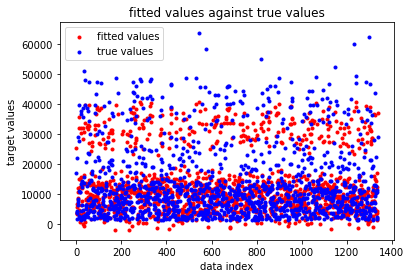

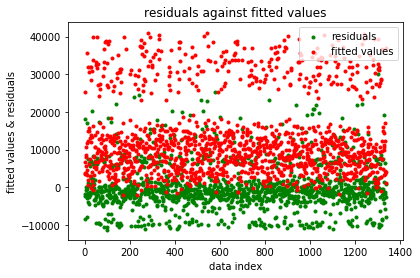

In [13]:
### 1(a)

# use OneHotEncoder to do one hot encoding for X
enc = OneHotEncoder(n_values='auto', categorical_features=[3,4,5], sparse=False, handle_unknown='error')
X_enc1 = enc.fit_transform(X)


# define a linear model and do the cross validation, report RMSE for training data and testing data
linear_model = LinearRegression(fit_intercept=True)
#mse_cv1 = cross_validate(linear_model, X_enc1, y, return_train_score=True, scoring='neg_mean_squared_error')
train_rmse1, test_rmse1 = k_fold_cv_rmse(linear_model,10,X_enc1,y)
     
# train a linear model and use it to predict
linear_model = LinearRegression(fit_intercept=True)
linear_model.fit(X_enc1,y)
y_pred1 = linear_model.predict(X_enc1)


# plot fitted values against true values as scatter plots using the whole dataset
# Plot residuals versus fitted values as scatter plots using the whole dataset
plot_target_val_and_residual(y,y_pred1)

C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:390: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


RMSE for training data is:  6039.250426233231
RMSE for testing data is:  6062.636312256011


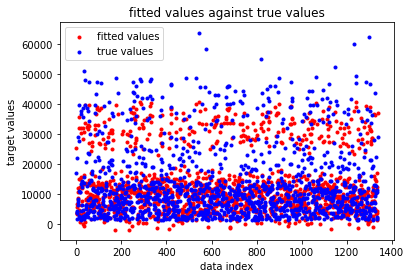

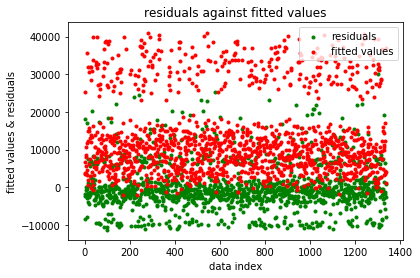

In [14]:
### 1(b)

#Standardize all these numerical features and keep the one-hot-encoded features
X_standardized = X
X_standardized[:,0:3] = scale(X_standardized[:,0:3], axis=0, with_mean=True, with_std=True,copy=True)    # standarize numerical features
enc = OneHotEncoder(n_values='auto', categorical_features=[3,4,5], sparse=False, handle_unknown='error')  
X_enc2 = enc.fit_transform(X_standardized)           # encode categorical features

# define a linear model and do the cross validation, report RMSE for training data and testing data
linear_model = LinearRegression(fit_intercept=True)
train_rmse2, test_rmse2 = k_fold_cv_rmse(linear_model,10,X_enc2,y)

# train a linear model and use it to predict
linear_model = LinearRegression(fit_intercept=True)
linear_model.fit(X_enc2,y)
y_pred2 = linear_model.predict(X_enc2)


# plot fitted values against true values as scatter plots using the whole dataset
# Plot residuals versus fitted values as scatter plots using the whole dataset
plot_target_val_and_residual(y,y_pred1)

C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:390: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


RMSE for training data is:  6198.508413104524
RMSE for testing data is:  6221.0843850934525


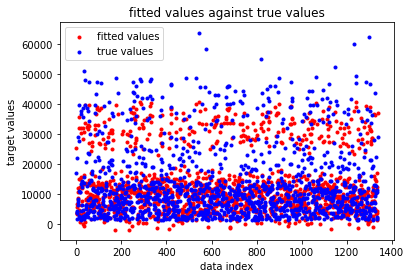

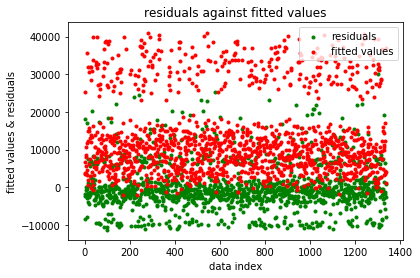

In [15]:
### 1(c)
# get the values for features and target
n_row,n_cols = insurance_df.shape
X = insurance_df.iloc[:,0:n_cols-1].values
y = insurance_df.iloc[:,n_cols-1].values

# redefine ft1           
for i in range(len(X[:,0])):
    if X[i,0]<30:
        X[i,0] = 1                     #X[:,0][X[:,0]<30] = 1
    elif X[i,0]>=30 and X[i,0]<=50:
        X[i,0] = 2
    else:
        X[i,0] = 3

# standardize ft2,ft3 and perform OneHotEncoder to ft4,ft5.ft6
X_standardized = X
X_standardized[:,1:3] = scale(X_standardized[:,1:3], axis=0, with_mean=True, with_std=True,copy=True)    # standarize numerical features
enc = OneHotEncoder(n_values='auto', categorical_features=[3,4,5], sparse=False, handle_unknown='error')  
X_enc3 = enc.fit_transform(X_standardized)           # encode categorical features


# define a linear model and do the cross validation, report RMSE for training data and testing data
linear_model = LinearRegression(fit_intercept=True)
train_rmse3, test_rmse3 = k_fold_cv_rmse(linear_model,10,X_enc3,y)
      


# train a linear model and use it to predict
linear_model = LinearRegression(fit_intercept=True)
linear_model.fit(X_enc3,y)
y_pred3 = linear_model.predict(X_enc3)


# plot fitted values against true values as scatter plots using the whole dataset
# Plot residuals versus fitted values as scatter plots using the whole dataset
plot_target_val_and_residual(y,y_pred1)

[1868.35109234 1726.07411819  524.29453691  586.80312699  284.25189929
  610.77704565] [3.95160002e-256 6.10442144e-243 3.63529334e-098 8.98169775e-108
 5.61231739e-058 2.24789404e-111]
the best two features for f_regression is: ft1 and ft2 
[1.49984053 0.07283945 0.16156756 0.17665987 0.36917105 0.0758473 ]
the best two features for mutual_info_regression is: ft1 and ft5 


Text(0.5, 1.0, 'charges vs. ft1')

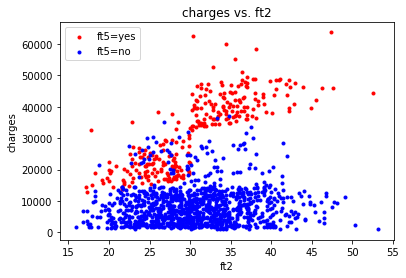

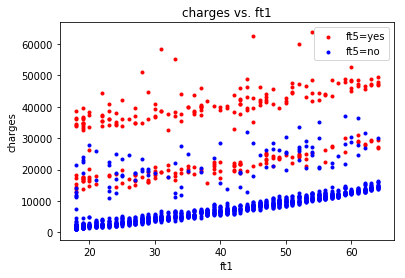

In [16]:
### 2
# get the values for features and target
n_row,n_cols = insurance_df.shape
X = insurance_df.iloc[:,0:n_cols-1].values  # do not need to do one hot encoding
y = insurance_df.iloc[:,n_cols-1].values

# name of features
col_name = list(insurance_df.columns.values)

# use f_regression to decide the two most important features
f_score, f_pval = f_regression(X,y,center=False)
print(f_score,f_pval)
f_idx = np.argsort(-f_score)
first_idx_f = f_idx[0]
second_idx_f = f_idx[1]
print('the best two features for f_regression is: %s and %s ' %(col_name[first_idx_f],col_name[second_idx_f]))

# use mutual_info_regression to decide the two most important features
mutual_score = mutual_info_regression(X, y, discrete_features=False, n_neighbors=3, copy=True, random_state=None)
print(mutual_score)
mutual_idx = np.argsort(-mutual_score)
first_idx_m = mutual_idx[0]
second_idx_m = mutual_idx[1]
print('the best two features for mutual_info_regression is: %s and %s ' %(col_name[first_idx_m],col_name[second_idx_m]))

# divide datas into two parts based on ft5
X_yes = X[X[:,4]==0]
y_yes = y[X[:,4]==0]
X_no = X[X[:,4]==1]
y_no = y[X[:,4]==1]

# Scatter plot charges (y axis) vs ft2 (x axis), and color points based on ft5
plt.figure()
plt.scatter(X_yes[:,1], y_yes, marker='.', c='r', label='ft5=yes')
plt.scatter(X_no[:,1], y_no, marker='.', c='b', label='ft5=no')
plt.xlabel('ft2')
plt.ylabel('charges')
plt.legend()
plt.title('charges vs. ft2')

# Scatter plot charges (y axis) vs ft1 (x axis), and color points based on ft5
plt.figure()
plt.scatter(X_yes[:,0], y_yes, marker='.', c='r', label='ft5=yes')
plt.scatter(X_no[:,0], y_no, marker='.', c='b', label='ft5=no')
plt.xlabel('ft1')
plt.ylabel('charges')
plt.legend()
plt.title('charges vs. ft1')

C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:390: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


RMSE for training data is:  8358.94095457355
RMSE for testing data is:  8373.795726572036


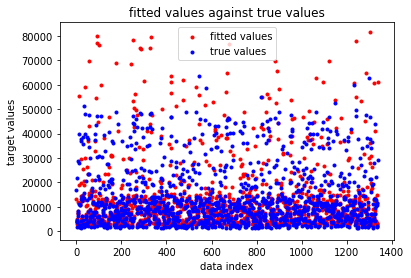

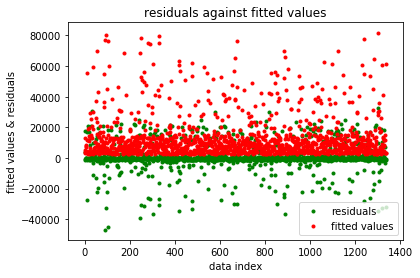

In [17]:
### 3(a)

# get the values for features and target
n_row,n_cols = insurance_df.shape
X = insurance_df.iloc[:,0:n_cols-1].values
y = insurance_df.iloc[:,n_cols-1].values


# transfer y to log(y)
y_new = np.log(y)
# use OneHotEncoder to do one hot encoding for X (that is, use the feature preprocessing method in 1a )
enc = OneHotEncoder(n_values='auto', categorical_features=[3,4,5], sparse=False, handle_unknown='error')
X_enc4 = enc.fit_transform(X)


# define a linear model and do the cross validation, report RMSE for training data and testing data
# we should calculate the difference between exp(log(y)predict) and y to set up a fair comparison
model = LinearRegression(fit_intercept=True)
kf = KFold(n_splits=10, shuffle=False, random_state=None)
train_rmse_list = []
test_rmse_list = []
for train_index, test_index in kf.split(X_enc4):                 
    X_train, y_train = X_enc4[train_index], y_new[train_index]           # training data (log(y))
    X_test, y_test = X_enc4[test_index], y_new[test_index]               # testing data  (log(y))
    model.fit(X_train,y_train)                                           # train a model with the training data
    y_train_pred = model.predict(X_train)                                # use the model we trained to predict y for training data
    y_test_pred = model.predict(X_test)                                  # use the model we trained to predict y for testing data
    train_rmse = np.sqrt(np.mean(np.square(np.exp(y_train_pred) - np.exp(y_train))))     # train_rmse 
    test_rmse = np.sqrt(np.mean(np.square(np.exp(y_test_pred) - np.exp(y_test))))        # test_rmse
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)
mean_train_rmse = np.mean(train_rmse_list)
mean_test_rmse = np.mean(test_rmse_list)
print('RMSE for training data is: ', mean_train_rmse)
print('RMSE for testing data is: ', mean_test_rmse)


# train a new linear model and predict the target values using X_enc4 and y_new
linear_model = LinearRegression(fit_intercept=True)
linear_model.fit(X_enc4,y_new)
y_new_pred = linear_model.predict(X_enc4)


# plot
plot_target_val_and_residual(y,np.exp(y_new_pred))
#plot_target_val_and_residual(y_new,y_new_pred)

[13711.75217411 30006.41746982  1156.77113563  1340.69946323
  3696.60624649  2156.00724551] [0.00000000e+000 0.00000000e+000 3.35302212e-183 7.05906006e-204
 0.00000000e+000 4.29888592e-281]
the best two features for f_regression is: ft2 and ft1 
[1.49917138 0.06817119 0.16101784 0.17628529 0.36939335 0.07753486]
the best two features for mutual_info_regression is: ft1 and ft5 


Text(0.5, 1.0, 'charges vs. ft1')

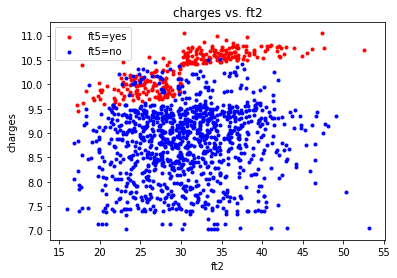

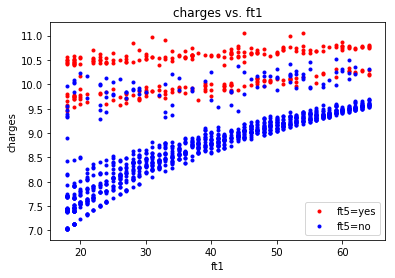

In [18]:
### 3(b)

# use f_regression to decide the two most important features
f_score_new, f_pval_new = f_regression(X,y_new,center=False)
idx_f_new = np.argsort(-f_score_new)
first_idx_f_new = idx_f_new[0]
second_idx_f_new = idx_f_new[1]
print(f_score_new,f_pval_new)
print('the best two features for f_regression is: %s and %s ' %(col_name[first_idx_f_new],col_name[second_idx_f_new]))

# use mutual_info_regression to decide the two most important features
mutual_score_new = mutual_info_regression(X, y_new, discrete_features=False, n_neighbors=3, copy=True, random_state=None)
print(mutual_score_new)
idx_m_new = np.argsort(-mutual_score_new)
first_idx_m_new = idx_m_new[0]
second_idx_m_new = idx_m_new[1]
print('the best two features for mutual_info_regression is: %s and %s ' %(col_name[first_idx_m_new],col_name[second_idx_m_new]))

# divide datas into two parts based on ft5
X_yes = X[X[:,4]==0]
y_new_yes = y_new[X[:,4]==0]
X_no = X[X[:,4]==1]
y_new_no = y_new[X[:,4]==1]

# Scatter plot charges (y axis) vs ft2 (x axis), and color points based on ft5
plt.figure()
plt.scatter(X_yes[:,1], y_new_yes, marker='.', c='r', label='ft5=yes')
plt.scatter(X_no[:,1], y_new_no, marker='.', c='b', label='ft5=no')
plt.xlabel('ft2')
plt.ylabel('charges')
plt.legend()
plt.title('charges vs. ft2')

# Scatter plot charges (y axis) vs ft1 (x axis), and color points based on ft5
plt.figure()
plt.scatter(X_yes[:,0], y_new_yes, marker='.', c='r', label='ft5=yes')
plt.scatter(X_no[:,0], y_new_no, marker='.', c='b', label='ft5=no')
plt.xlabel('ft1')
plt.ylabel('charges')
plt.legend()
plt.title('charges vs. ft1')


for degree = 1:
RMSE for training data is:  6039.342370581926
RMSE for testing data is:  6063.643882478562

for degree = 2:
RMSE for training data is:  5728.410918381174
RMSE for testing data is:  5855.987241091296

for degree = 3:
RMSE for training data is:  7050.409871408466
RMSE for testing data is:  7711.894658079864

for degree = 4:
RMSE for training data is:  4282.742056158859
RMSE for testing data is:  5739.427365591867

for degree = 5:
RMSE for training data is:  3723.480331264659
RMSE for testing data is:  10392.186973978918

for degree = 6:
RMSE for training data is:  3022.980801239834
RMSE for testing data is:  10564786.236812904


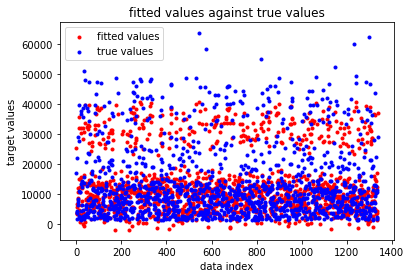

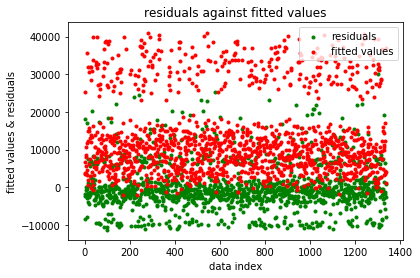

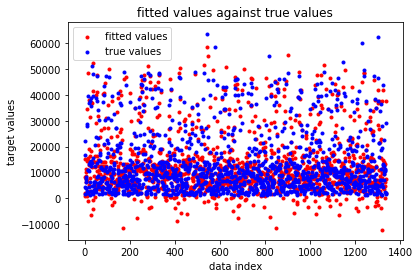

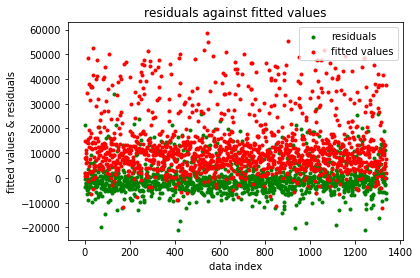

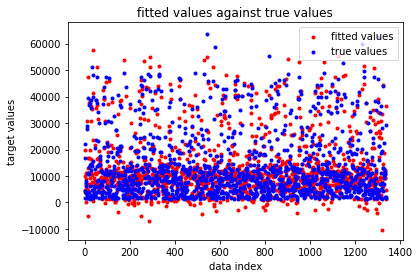

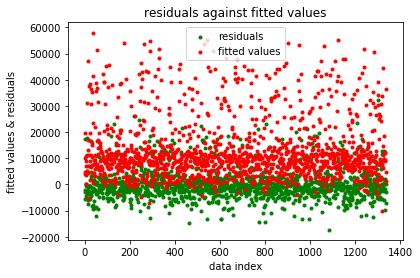

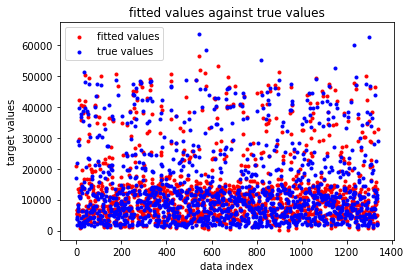

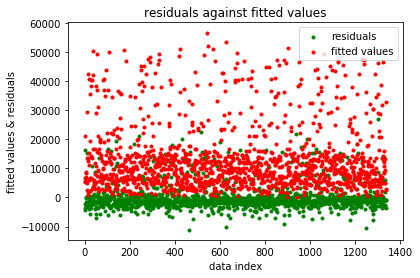

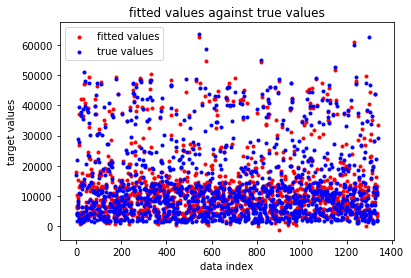

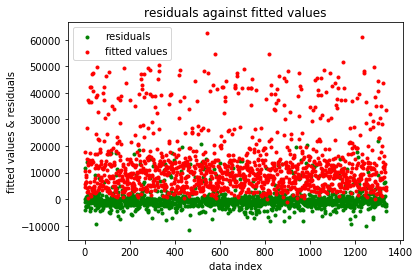

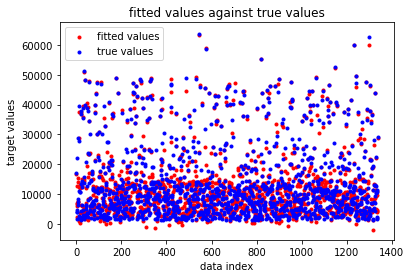

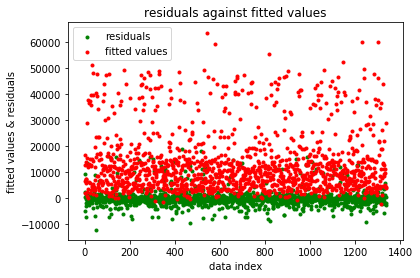

In [19]:
### 4(a) polynomial features
#(based on 1(a), use X_enc1 and y)
for degree in np.arange(1,7):
    # define polynomial features
    poly = PolynomialFeatures(degree)
    X_enc1_poly = poly.fit_transform(X_enc1)
    
    # define a linear model
    linear_model = LinearRegression(fit_intercept=True)
    
    # do the 10-fold cross validation for each degree and report the rmse
    print('\nfor degree = %s:' %degree)
    k_fold_cv_rmse(linear_model,10,X_enc1_poly,y)
    
    # use the whole dataset to train a model and plot target values and residuals
    linear_model.fit(X_enc1_poly,y)
    y_pred = linear_model.predict(X_enc1_poly)
    plot_target_val_and_residual(y,y_pred)


for num_estimator = 10, max_depth = 3:
RMSE for training data is:  4483.759439641308
RMSE for testing data is:  4610.82596056276

for num_estimator = 10, max_depth = 5:
RMSE for training data is:  4058.4356998855023
RMSE for testing data is:  4511.679978980557

for num_estimator = 10, max_depth = 7:
RMSE for training data is:  3351.4065706361243
RMSE for testing data is:  4662.639795809983

for num_estimator = 10, max_depth = 9:
RMSE for training data is:  2654.650840390031
RMSE for testing data is:  4903.330525684291

for num_estimator = 50, max_depth = 3:
RMSE for training data is:  4469.688777303151
RMSE for testing data is:  4573.635666380802

for num_estimator = 50, max_depth = 5:
RMSE for training data is:  4021.3580113306525
RMSE for testing data is:  4505.879928701777

for num_estimator = 50, max_depth = 7:
RMSE for training data is:  3259.6781117459905
RMSE for testing data is:  4582.619964447009

for num_estimator = 50, max_depth = 9:
RMSE for training data is:  2477.3559036

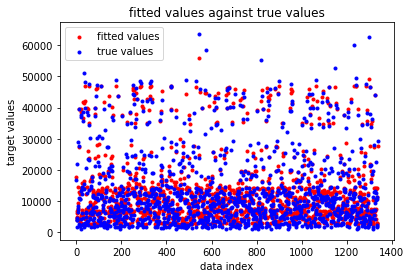

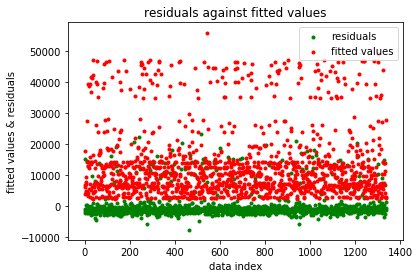

In [20]:
### 4(b) random forest
#(based on 1(a), use X_enc1 and y)

num_estimator_list = [10,50,100,300,600,1000]
max_depth_list = np.arange(3,11,2)

min_train_rmse = float('inf')
min_test_rmse = float('inf')
train_rmse_matrix = np.zeros([len(num_estimator_list),len(max_depth_list)])
test_rmse_matrix = np.zeros([len(num_estimator_list),len(max_depth_list)])

best_train_num_estimator = 0
best_test_num_estimator = 0
best_train_depth = 0
best_test_depth = 0

for i in range(len(num_estimator_list)):
    num_estimator = num_estimator_list[i]
    for j in range(len(max_depth_list)):
        depth = max_depth_list[j]
        # define a random forest regressor
        rand_forest = RandomForestRegressor(n_estimators=num_estimator, criterion='mse', 
                                            max_depth=depth, max_features='auto', 
                                            random_state=None)
        # do the 10-fold cross validation 
        print('\nfor num_estimator = %s, max_depth = %s:' %(num_estimator,depth))
        train_rmse, test_rmse = k_fold_cv_rmse(rand_forest,10,X_enc1,y)
        train_rmse_matrix[i,j] = train_rmse
        test_rmse_matrix[i,j] = test_rmse
        if train_rmse < min_train_rmse:
            min_train_rmse = train_rmse
            best_train_num_estimator = num_estimator
            best_train_depth = depth
        if test_rmse < min_test_rmse:
            min_test_rmse = test_rmse
            best_test_num_estimator = num_estimator
            best_test_depth = depth
            
print('train_rmse_matrix is :\n',train_rmse_matrix)
print('test_rmse_matrix is :\n',test_rmse_matrix)
print('the minimum train RMSE (when num_estimator = %s, max_depth = %s) is: %s'
      %(best_train_num_estimator,best_train_depth,min_train_rmse))       
print('the minimum test RMSE (when num_estimator = %s, max_depth = %s) is: %s'
      %(best_test_num_estimator,best_test_depth,min_test_rmse))   

# use the best model(with the minimum test RMSE) to train a model and plot the target values and residuals
rand_forest = RandomForestRegressor(n_estimators=best_test_num_estimator, criterion='mse', 
                                    max_depth=best_test_depth, max_features='auto', 
                                    random_state=None)
rand_forest.fit(X_enc1,y)
y_pred = rand_forest.predict(X_enc1)
plot_target_val_and_residual(y,y_pred)
print('RMSE for the whole dataset is:',np.sqrt(np.mean(np.square(y_pred - y))))

RMSE for training data is:  4784.359669795229
RMSE for testing data is:  4851.377676078211


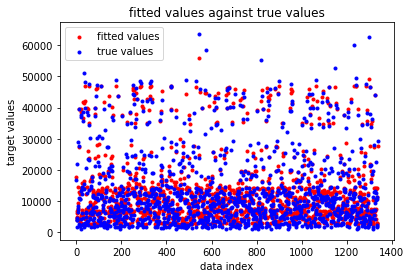

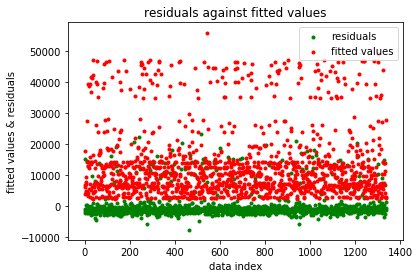

In [21]:
###   4(b) neural network
#(based on 1(a), use X_enc1 and y)

# define a random forest regressor
MLP = MLPRegressor(hidden_layer_sizes=(100,),activation='relu', solver='adam', 
                   alpha=0.0001, batch_size=800, learning_rate='constant', learning_rate_init=0.015, 
                   power_t=0.5, max_iter=3000, shuffle=True, random_state=None, tol=0.0001, verbose=False, 
                   warm_start=False, momentum=0.9, nesterovs_momentum=True, 
                   early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, 
                   epsilon=1e-08)

# do the 10-fold cross validation 
train_rmse, test_rmse = k_fold_cv_rmse(MLP,10,X_enc1,y)

# use the model to train a model and plot the target values and residuals
MLP.fit(X_enc1,y)
y_pred = rand_forest.predict(X_enc1)
plot_target_val_and_residual(y,y_pred)


for num_estimator = 10, max_depth = 1:
RMSE for training data is:  8170.0128621440435
RMSE for testing data is:  8157.661852936481

for num_estimator = 10, max_depth = 2:
RMSE for training data is:  6267.875544920719
RMSE for testing data is:  6283.849652919497

for num_estimator = 10, max_depth = 3:
RMSE for training data is:  5953.721090911005
RMSE for testing data is:  6015.673367699804

for num_estimator = 10, max_depth = 4:
RMSE for training data is:  5815.186850858264
RMSE for testing data is:  5961.270009290141

for num_estimator = 10, max_depth = 5:
RMSE for training data is:  5672.672802470553
RMSE for testing data is:  5960.725846410127

for num_estimator = 50, max_depth = 1:
RMSE for training data is:  6192.880944830815
RMSE for testing data is:  6263.639690546508

for num_estimator = 50, max_depth = 2:
RMSE for training data is:  4343.466639003262
RMSE for testing data is:  4499.84713007909

for num_estimator = 50, max_depth = 3:
RMSE for training data is:  4073.7197973548

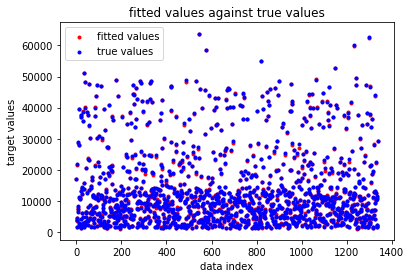

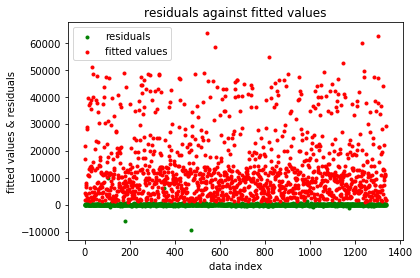

In [22]:
###   4(b) gradient boosting forest
#(based on 1(a), use X_enc1 and y)

num_estimator_list = [10,50,100,300,500,1000]
max_depth_list = np.arange(1,6)

min_train_rmse = float('inf')
min_test_rmse = float('inf')
train_rmse_matrix = np.zeros([len(num_estimator_list),len(max_depth_list)])
test_rmse_matrix = np.zeros([len(num_estimator_list),len(max_depth_list)])

best_train_num_estimator = 0
best_test_num_estimator = 0
best_train_depth = 0
best_test_depth = 0

for i in range(len(num_estimator_list)):
    num_estimator = num_estimator_list[i]
    for j in range(len(max_depth_list)):
        depth = max_depth_list[j]
        # define a random forest regressor
        grad_boosting_tree = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=num_estimator, 
                                                        max_depth=depth, random_state=None, max_features=None, alpha=0.9)
        print('\nfor num_estimator = %s, max_depth = %s:' %(num_estimator,depth))
        train_rmse, test_rmse = k_fold_cv_rmse(grad_boosting_tree,10,X_enc1,y)
        train_rmse_matrix[i,j] = train_rmse
        test_rmse_matrix[i,j] = test_rmse
        if train_rmse < min_train_rmse:
            min_train_rmse = train_rmse
            best_train_num_estimator = num_estimator
            best_train_depth = depth
        if test_rmse < min_test_rmse:
            min_test_rmse = test_rmse
            best_test_num_estimator = num_estimator
            best_test_depth = depth
            
print('train_rmse_matrix is :\n',train_rmse_matrix)
print('test_rmse_matrix is :\n',test_rmse_matrix)
print('the minimum train RMSE (when num_estimator = %s, max_depth = %s) is: %s'
      %(best_train_num_estimator,best_train_depth,min_train_rmse))       
print('the minimum test RMSE (when num_estimator = %s, max_depth = %s) is: %s'
      %(best_test_num_estimator,best_test_depth,min_test_rmse))   


# use the best model(with the minimum test RMSE) to train a model and plot the target values and residuals
grad_boostiing_tree = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=best_test_num_estimator, 
                                                max_depth=best_test_depth, random_state=None, max_features=None, alpha=0.9)
grad_boosting_tree.fit(X_enc1,y)
y_pred = grad_boosting_tree.predict(X_enc1)
plot_target_val_and_residual(y,y_pred)